C:\Users\Mariem\AppData\Local\Temp\ipykernel_18836\3288283523.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
D:\annaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


📊 Silhouette Scores - Clustering des Entrepôts
KMeans         : 0.532
DBSCAN         : 0.5315039401550833
Agglomerative  : 0.532


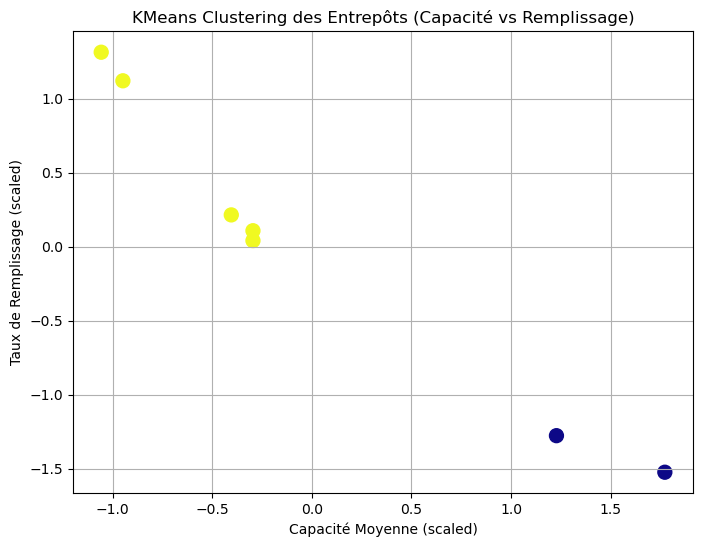


📦 Entrepôts segmentés :
   Warehouse_PK             Warehouse_Name  Nb_Produits  Total_Quantite  \
0             1  entrepot central de tunis          600           30887   
1             4   hub de stockage de gabes          600           30167   
2             7  centre logistique de sfax          600           30271   
3            10          entrepot de gafsa          600           29952   
4            13   point logistique de douz          600           29993   
5            20   entrepot central de beja          600           30415   
6            25             depot du bardo          600           30146   

   Capacite_Moyenne  Taux_Remplissage  KMeans  
0               500             61.77       0  
1               250            120.67       1  
2               450             67.27       0  
3               310             96.62       1  
4               240            124.97       1  
5               310             98.11       1  
6               300            100.49 

In [10]:
import pandas as pd
import pyodbc
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 🔌 Connexion SQL Server
conn = pyodbc.connect(
    'DRIVER={SQL Server};SERVER=DESKTOP-OQ959SK;DATABASE=FinalDW;Trusted_Connection=yes;'
)

# 📥 Requête SQL enrichie pour les entrepôts
query = '''
SELECT 
    w.Warehouse_PK,
    w.Warehouse_Name,
    COUNT(DISTINCT fw.Prod_FK) AS Nb_Produits,
    COUNT(*) AS Nb_Enregistrements,
    SUM(fw.Quantity) AS Total_Quantite,
    AVG(fw.Capacity) AS Capacite_Moyenne,
    ROUND(SUM(fw.Quantity) * 1.0 / NULLIF(AVG(fw.Capacity), 0), 2) AS Taux_Remplissage
FROM 
    Dim_Warehouse w
JOIN 
    Fact_Warehousing fw ON fw.Warehouse_FK = w.Warehouse_PK
GROUP BY 
    w.Warehouse_PK, w.Warehouse_Name
HAVING 
    COUNT(*) > 5
'''

# 📥 Extraction des données depuis SQL Server
df = pd.read_sql(query, conn)
conn.close()

# 🔄 Standardisation des données
X = df[['Nb_Produits', 'Total_Quantite', 'Capacite_Moyenne', 'Taux_Remplissage']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🤖 KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_score = silhouette_score(X_scaled, kmeans_labels)

# 🤖 DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=2)
dbscan_labels = dbscan.fit_predict(X_scaled)
dbscan_score = silhouette_score(X_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else "N/A"

# 🤖 Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=2)
agglo_labels = agglo.fit_predict(X_scaled)
agglo_score = silhouette_score(X_scaled, agglo_labels)

# 📊 Ajout des résultats dans le DataFrame
df['KMeans'] = kmeans_labels
df['DBSCAN'] = dbscan_labels
df['Agglomerative'] = agglo_labels

# 🎯 Affichage des scores de silhouette pour chaque méthode de clustering
print("📊 Silhouette Scores - Clustering des Entrepôts")
print(f"KMeans         : {kmeans_score:.3f}")
print(f"DBSCAN         : {dbscan_score}")
print(f"Agglomerative  : {agglo_score:.3f}")

# 📈 Visualisation 2D pour KMeans
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 2], X_scaled[:, 3], c=kmeans_labels, cmap='plasma', s=100)
plt.title("KMeans Clustering des Entrepôts (Capacité vs Remplissage)")
plt.xlabel("Capacité Moyenne (scaled)")
plt.ylabel("Taux de Remplissage (scaled)")
plt.grid(True)
plt.show()

# 📋 Aperçu final avec les résultats de clustering
print("\n📦 Entrepôts segmentés :")
print(df[['Warehouse_PK', 'Warehouse_Name', 'Nb_Produits', 'Total_Quantite', 'Capacite_Moyenne', 'Taux_Remplissage', 'KMeans']])
